[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MatteoFalcioni/Learning-LangGraph/blob/main/notebooks/5_command.ipynb)

### Setup

#### Install requirements

In [ ]:
%pip install -q -U -r https://raw.githubusercontent.com/MatteoFalcioni/Learning-LangGraph/main/requirements.txt

#### local (notebooks or files)

In [ ]:
from dotenv import load_dotenv
load_dotenv()  # load api keys

True

#### Colab

In [ ]:
from google.colab import userdata
import os

REQUIRED_KEYS = [
    'OPENAI_API_KEY',
    'LANGSMITH_TRACING',
    'LANGSMITH_ENDPOINT',
    'LANGSMITH_API_KEY',
    'LANGSMITH_PROJECT'
]

def _set_colab_keys(key : str):
    # Retrieve the secret value using its key/name
    secret_value = userdata.get(key)
    # set it as a standard OS environment variable
    os.environ[key] = secret_value

for key in REQUIRED_KEYS:
    _set_colab_keys(key)

## The `Command` Primitive

[`Command`](https://reference.langchain.com/python/langgraph/types/?h=#langgraph.types.Command) is a native type in LangGraph, that is *extremely useful for graph building and routing*. 

It can be useful in 3 cases:

1. combining control flow (edges) and state updates (nodes). For example, you might want to BOTH perform state updates AND decide which node to go to next in the SAME node;

2. updating state from tools;

3. creating *handoff tools* (supervised workflows - see next notebooks..)

We will go through the use cases one by one:

## 1. `Command` in Nodes: combining control flows and state updates  

Let's already look at an example: in the following we have our node that does two things:

- performs a state update of state variable `counter`;
- routes to the next node.
    
We do both things in the node by returning a `Command`:

```python
def update_counter_node(state: MyState) -> Command[Literal["my_other_node"]]:
    return Command(
        # state update
        update={"counter": +1},  # again, dictionary of updates
        # control flow
        goto="my_other_node"   
    )
```

Notice what type hint we are specifying as the return type: `-> Command[Literal["my_other_node"]]`

This is a must-do for routing with `Command`: we need to specify the possible next nodes as `Literal[<node_name>]`. 

They can be more than one node if want to have conditional routing:

```python
def node_a(state: MyState) -> Command[Literal["node_b", "node_c"]]:
    """
    Node that performs an update on state, then routes to either node_b or node_c
    """
    choice = random.choice(["b"], ["c"])
    # this replaces a conditional edge 
    if value == "b":
        goto = "node_b"
    else:
        goto = "node_c"
    
    return Command(
        update={"counter" : +1}
        goto=goto
    )
```

### End to end basic example

Let's make an end-to-end example. Let’s create a simple graph with 3 nodes: A, B and C. We will first execute node A, and then decide whether to go to Node B or Node C next based on the output of node A.

In [ ]:
import random
from typing_extensions import TypedDict, Literal, Annotated
from langgraph.graph import StateGraph, START
from langgraph.types import Command

# Define reducer
def add_str(left: str | None, right: str | None) -> str:
    "reducer to combine strings instead of overwriting them"
    if left is None:
        left = ""
    if right is None:
        right = ""
    return left + right

# Define graph state
class MyState(TypedDict):
    foo: Annotated[str, add_str]

# Define the nodes
def node_a(state: MyState) -> Command[Literal["node_b", "node_c"]]:
    print("Called A")
    value = random.choice(["b", "c"])
    # this is a replacement for a conditional edge function. In this example we just choose randomly
    if value == "b":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update
        update={"foo": value},
        # this is a replacement for an edge
        goto=goto,
    )


def node_b(state: MyState):
    print("Called B")
    return {"foo": "b"}  # Defined the reducer so we can update like this

def node_c(state: MyState):
    print("Called C")
    return {"foo": "c"}

We can now create the `StateGraph` with the above nodes. Notice that **the graph doesn’t have conditional edges for routing!** This is because control flow is defined with `Command` inside `node_a`.

In [ ]:
builder = StateGraph(MyState)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(node_b)
builder.add_node(node_c)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

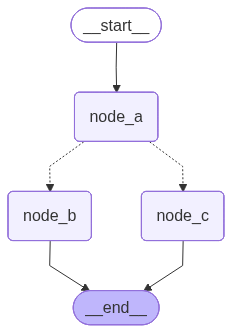

In [3]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"foo": ""})

Called A
Called C


{'foo': 'cc'}

## 2. `Command` Used in Tools

A common use case is updating graph state from inside a tool. For example, let's say that we have a tool that our agent can call to execute python code. Let's also say that we want to keep track of the executed code in a state variable `code_logs`.

To update the graph state from the tool, we can return a Command with a dictionary of updates in the tool return:

```python  
from langchain.tools import tool
import io
import sys
import contextlib

@tool
def execute_code(code : Annotated[str, "The Python code to execute"]):
    """
    Use this to execute Python code.
    """

    result = repl.execute(code)

    std_out = result.get('out', '')
    std_err = result.get('err', '')

    return Command(
        update={
            # Update state keys
            "code_logs": [
                {  
                    "input": code,
                    "output": {
                        'out': std_out,
                        'err': std_err
                    }
                }
            ],
            # Update message keys
            "messages": [
                ToolMessage(
                    content=f"Executed Python code w/ output\n{std_out}\n\nerrors:{std_err}", 
                    tool_call_id='exec_1257563'
                )
            ]
        }
    )
```

You MUST include `messages` (or any state key used for the message history) in `Command.update` when returning `Command` from a tool and the list of messages in messages MUST contain a `ToolMessage`. This is necessary for the resulting message history to be valid (LLM providers require AI messages with tool calls to be followed by the tool result messages).

## `ToolRuntime` *- Always use it when using `Command` in tools*

When you pass a state directly as a function parameter, the model sees it in the tool signature, which means the LLM thinks it can control that state as input. 

With [`ToolRuntime`](https://docs.langchain.com/oss/python/langchain/runtime#inside-tools), the parameter remains invisible to the model – it does not appear in the tool schema that the LLM sees.

**This is also a must do when returning a `Command` from tools, since we need the `runtime.tool_call_id` in order to return a `ToolMessage`.**

### Wrong Approach

```python 
@tool
def my_tool(state: MyState) -> str:
    """Fai qualcosa."""
    return state.user_id

### Right Approach
```python
from langchain.tools import tool, ToolRuntime

@tool
def my_tool(runtime: ToolRuntime) -> str:
    """Fai qualcosa."""
    user_id = runtime.state["user_id"]
    return f"User is {user_id}"

### Practical Example

In [5]:
from langchain.agents import create_agent, AgentState
from langchain.tools import tool, ToolRuntime
from langchain_core.messages import ToolMessage
from langgraph.types import Command

class CustomState(AgentState):
    user_id: str

@tool
def get_user_info(runtime: ToolRuntime) -> str:
    """Look up user info."""
    user_id = runtime.state["user_id"]  
    result_string = "User is John Smith" if user_id == "user_123" else "Unknown user"
    return Command(
        update = {
            "messages" : [ToolMessage(content=result_string, tool_call_id=runtime.tool_call_id)]
        }
    )

agent = create_agent(
    model="gpt-4o",
    tools=[get_user_info],
    state_schema=CustomState,
)

result = agent.invoke({
    "messages": "look up user information",
    "user_id": "user_123"  
})

In [6]:
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

look up user information
================================== Ai Message ==================================
Tool Calls:
  get_user_info (call_5MvxrfRC7OBftp2hC44TXV9P)
 Call ID: call_5MvxrfRC7OBftp2hC44TXV9P
  Args:
================================= Tool Message =================================
Name: get_user_info

User is John Smith
================================== Ai Message ==================================

The user information is: John Smith.


### NOTE: Propagating Tool Updates 

There is a catch that is the source of many errors and misunderstandings while using `Command` in tools. 

When we return a `Command(update={...})` in the tools, but invoke the agent that uses those tools in a node, these updates are not automatically propagated to the general state of the graph. They 'remain in that node' if we do not propagate them manually. 

Let's see an example to make things clearer; let's say that I have a tool that runs Python code and saves the result in a state var `code_logs`:

```python
@tool 
def execute_code(code: str, runtime: ToolRuntime) -> Command:
    """
    Dummy implementation of a tool that executes Python code.
    """

    # fake implementation (we'll do it for real later on)
    result = execute(code)
    std_out = result.get('out', '')   

    return Command(
        update={
            "messages" : [ToolMessage(content=f"code executed succesfully", tool_call_id=runtime.tool_call_id)]
            "code_logs" : [std_out]
        }
    )
```

Let's say we give this tool to an agent, that we'll invoke in a node:

```python
agent = create_agent(
    model="gpt-4o",
    tools=[execute_code],
    state_schema=CustomState,
)

def invoke_agent(state: CustomState) -> Command[Literal['__end__']]:
    """
    Invokes the agent.
    """

    result = agent.invoke(state)   # in here the agent does all its work: calls tools until it decides its workflow is over
    # NOTE: result is a CustomState object, i.e., it's a dictionary with the keys we defined!
    # It's important to understand that **the agent modified our state and produced a new state** (`result`)
    # so now we extract the new state vars 
    last_msg = result['messages'][-1]
    code_logs = result['code_logs']

    # and now we **propagate the state updates to the general state**
    # Note that our tool already had a Command(update={...}) as a return; but this only updated the state of the single agent
    # We want to update the general state so the whole graph can see it.
    return Command(
        update={
            "messages" : [AIMessage(content=last_msg.content)],
            "code_logs" : code_logs 
        }
    )

```



---

## Exercises

For the following exercises there is no need to create a full working example with a graph: you can just do what the exercise asks.

- **5.1**: Create a node that checks a meaningful state variable (for example, a counter, a username, etc.) and based on the result routes to either the 'accepted_path' node or 'rejected_path' node. You must use `Command(goto=<node name>)` to route AND `runtime.state[<state var>]` to check state.

- **5.2**: Create a tool that leverages `Command` to make state updates. Use `runtime` to access the correct `tool_call_id`. 